# Fit an image model to ALMA uv data for HR 4796A's debris ring
This notebook takes about 15min to execute on a decent iMac.

In [1]:
import os
import numpy as np
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
from multiprocessing import Pool
import galario.double as gd
from galario import arcsec

import alma.image

%matplotlib notebook

In [2]:
# this may be needed to avoid emcee hanging when using multiple threads
# gd.threads(num=1)

In [3]:
# be nice, if you like
# niceness=os.nice(0)
# os.nice(11-niceness)

## creating the uv table
This can be exported from the measurement set (ms) file using uvplot from within CASA. The ms file is first created from the full ms by keeping only the target of interest and the intents that observe it, and averaging the channels down to something manageable. The column with the data after this step is 'data'.

We can then export from CASA with uvplot or a routine in alma.casa. uvplot will export baselines in meters, and which channel/spw each visibility came from is lost in the export (and wavelengths need to be used later to convert to wavelengths). The alma.casa exports uv in wavelengths, using the wavelength of each channel. This is preferred if there is enough s/n that the difference in uv across the spws matters.

An example for uvplot:
```python
import uvplot
uvplot.io.export_uvtable('uv-spw0-w64-t30.txt', tb, vis='calibrated_cont_selfcal.ms',
                         split=split, keep_tmp_ms=True, datacolumn='DATA',
                         channel='all',
                         split_args={'vis':'calibrated_cont_selfcal.ms',                            
                                     'spw':'0', 'keepflags':False, 'timebin':'30s', 'width':64,       
                                     'outputvis':'calibrated_cont_selfcal.spw0.w64-t30.ms',
                                     'datacolumn':'DATA'                                   
                                    }                   
                        )    
```

An example for alma.casa (where we have already used split to average the data to one channel per spw):
```python
alma.casa.export_ms('hr476-avg.ms/', casac.table(), casac.ms(), outfile='hr4796.npy')
```
The routine will output the average wavelength, which needs to be used below to estimate the primary beam size.

In [4]:
# import the visibilities, assuming alma.casa
uv_file = 'hr4796.npy'
u, v, Re, Im, w = np.load(uv_file)

# estimate re-weighting factor (so that chi^2 for null model would be 1, and d.o.f = 2*len(w))
reweight_factor = 2*len(w) / np.sum( (Re**2.0 + Im**2.0) * w )
print('reweighting factor is {}'.format(reweight_factor))

reweighting factor is 0.2676473416626641


In [5]:
# set image properties, can alter f_max for higher or lower resolution
# (here 1.25 instead of 2.5, which gives speed at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True, f_max=2.5)
dxy_arcsec = dxy / arcsec

dxy:1.888180e-02arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:7.733987e+00arcsec


In [6]:
# decide what model we want to use, and where we will put the results
model_name = 'gauss_3d'
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [7]:
# make the image object. by default this is asisymmetric
# (i.e. model='los_image_axisym', and has no anomaly parameter)
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy),
                      dens_model=model_name, z_fact=1, wavelength=0.8798e-3)

model:los_image_axisym with density:gauss_3d and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$i$', '$F$', '$r_0$', '$\\sigma_r$', '$\\sigma_h$']
rmax not set, run compute_rmax before generating images (may not apply to all density models)


In [8]:
# or we could make an image object with a custom density,
# here an eccentric ring that uses a non-axisymmetric function
# for this we would set 'model_name' above to 'custom_2d'

# def dfunc(r,az,el,p):
#     r_ecc = p[0] * ( 1 - p[1]**2 ) / ( 1 + p[1]*np.cos(az) )
#     return np.exp( -0.5*( (r-r_ecc)/p[2] )**2 ) * \
#            np.exp( -0.5*( el/0.05 )**2 ) * \
#            (1 - p[1]*np.cos(az))

# ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy),
#                       model='los_image', z_fact=2, wavelength=wavelength,
#                       dens_model=model_name,
#                       dens_args={'func':dfunc,
#                                  'params':['$a$','$e$','$\sigma_r$'],
#                                  'p_ranges':[[0.001,1],[0.,1],[0.001,1]]})

In [9]:
# add weight factor to parameter list, see likelihood calculation below
ii.params += ['$f_{w}$']
ii.p_ranges += [[0,10]]
ii.n_params += 1

In [10]:
# initial parameters, these need to be guessed
p0 = [0.030739811922506854,0.030302768261930402,26.657842043884354,76.65713506056193,
      0.015178783020528469,1.0784441832635718,0.05923657938474169]

if model_name == 'gauss_3d':     p0 += [0.04]
if model_name == 'custom_2d':    p0 = [-0.002, -0.052, 26.0, -70.0, 78, 0.014, 1., 0.1, 0.1]

p0 += [reweight_factor]
    
p0 = np.array(p0)
    
print('parameters and ranges for {}'.format(model_name))
for i in range(ii.n_params):
    print('{}\t{}\t{}'.format(p0[i],ii.p_ranges[i],ii.params[i]))

parameters and ranges for gauss_3d
0.030739811922506854	[-inf, inf]	$x_0$
0.030302768261930402	[-inf, inf]	$y_0$
26.657842043884354	[-270, 270]	$\Omega$
76.65713506056193	[0.0, 120]	$i$
0.015178783020528469	[0.0, inf]	$F$
1.0784441832635718	[0.0, inf]	$r_0$
0.05923657938474169	[0.001, inf]	$\sigma_r$
0.04	[0.01, 1.0]	$\sigma_h$
0.2676473416626641	[0, 10]	$f_{w}$


radial r_max: 66 pix at 1.628012424152958,1.604866137145431
model x,y,z extent 20, 66, 64
74.6 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


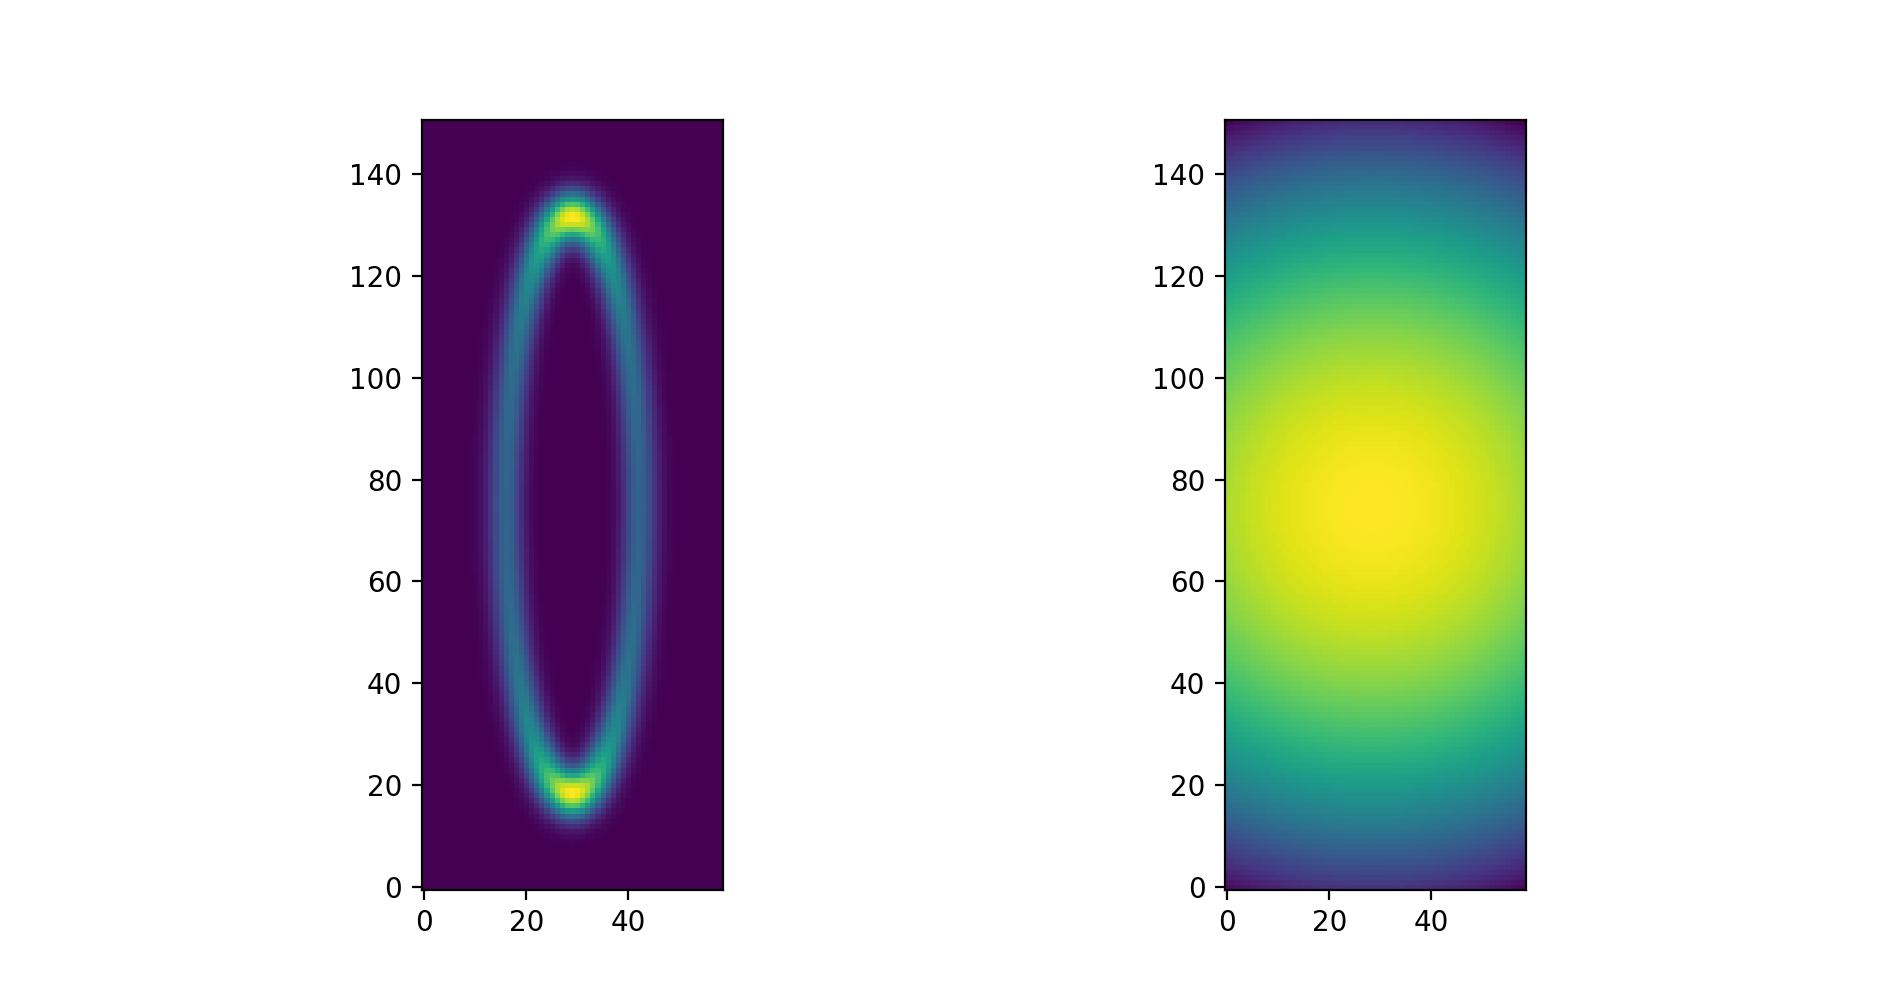

In [11]:
# set size of cutout used to generate images, which is based on the
# initial parameters. The tolerance in compute_rmax might be
# varied if the crop size turns out too large. We set 'zero_node'
# to True because we'll generate unrotated images, and let galario
# do the rest
ii.compute_rmax(p0, tol=1e-2, expand=10, zero_node=True)

# this gives an idea of how long an mcmc might take
%timeit ii.image_galario(p0[3:])

# show an image and the primary beam
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(im[ii.cc_gal], origin='bottom')
ax[1].imshow(ii.pb[ii.cc_gal], origin='bottom')

In [12]:
def lnpostfn(p):
    """ Log of posterior probability function """

    for x,r in zip(p,ii.p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # we generate the image with PA = North, origin in lower left,
    # and including primary beam correction
    image = ii.image_galario(p[3:]) * ii.pb_galario

    # galario translates and rotates it for us
    chi2 = gd.chi2Image(image, dxy, u, v, Re, Im, w, origin='lower',
                        dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )

    # return the merit function, here we require the weights are normally distributed
    # about the model as a Gaussian with the correct normalisation
    return -0.5 * ( chi2*p[-1] + np.sum(2*np.log(2*np.pi/(w*p[-1]))) )
#     return -0.5 * chi2

nlnpostfn = lambda p: -lnpostfn(p)

In [13]:
# check it works
lnpostfn(p0)

1753564.593606557

1753664.1124875152


<IPython.core.display.Javascript object>


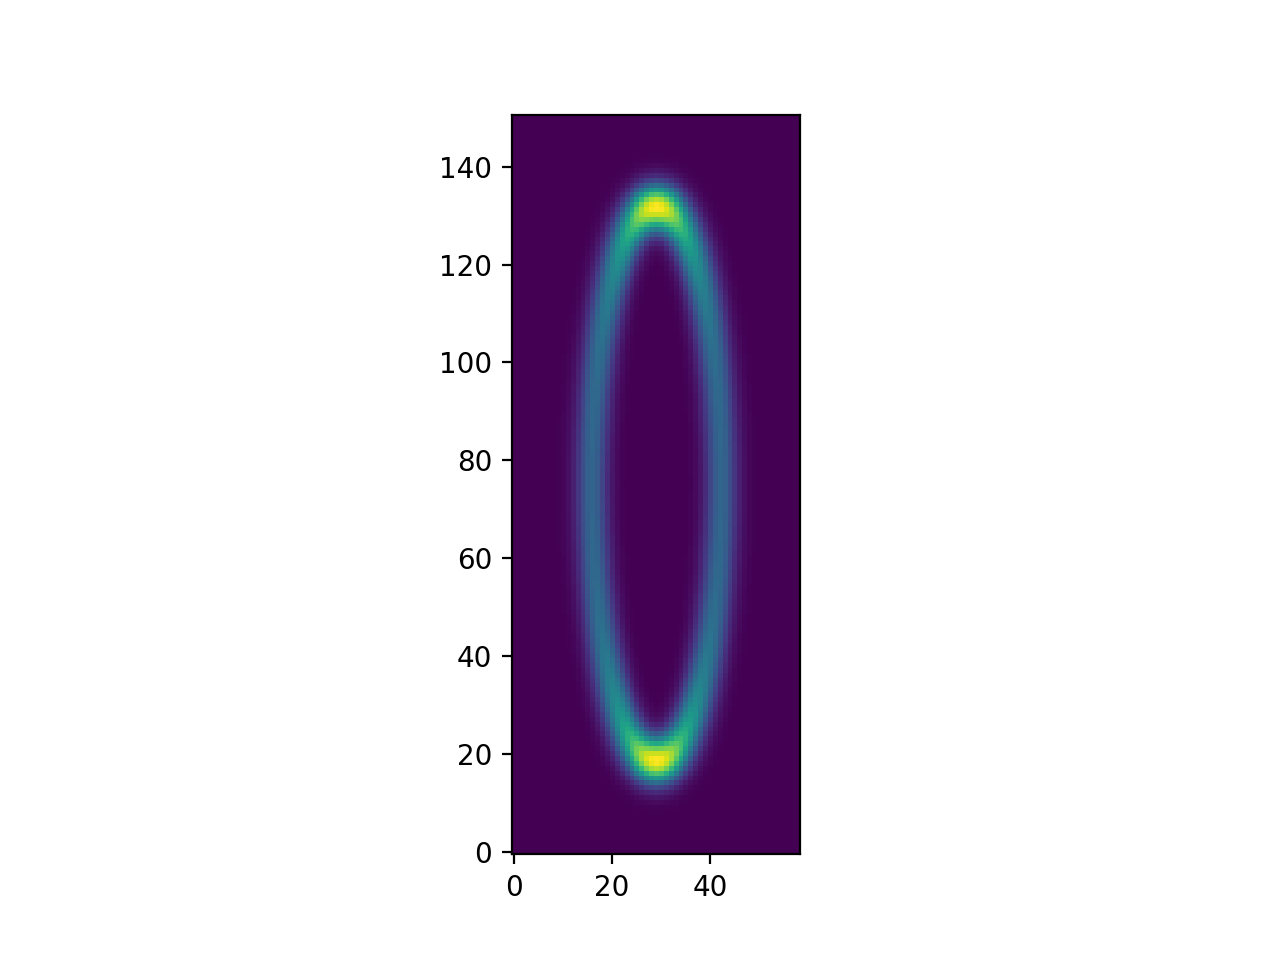

In [14]:
# get a best fit to estimate mcmc starting params
res = scipy.optimize.minimize(nlnpostfn, p0, method='Nelder-Mead',
                             options={'maxiter':100})
# print(res['x'])
p0 = np.array(res['x'])
print(lnpostfn(p0))

# show the image, before translation and rotation
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots()
ax.imshow(im[ii.cc_gal],origin='bottom')

In [15]:
# set up and run mcmc fitting
ndim = ii.n_params        # number of dimensions
nwalkers = 18             # number of walkers
nsteps = 500              # total number of MCMC steps
nthreads = 8              # CPU threads that emcee should use

# we are using emcee v3
with Pool(processes=nthreads) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, pool=pool)

    # initialize the walkers with an ndim-dimensional Gaussian ball
    pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]

    # execute the MCMC
    pos, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 500/500 [10:18<00:00,  1.18s/it]


<IPython.core.display.Javascript object>


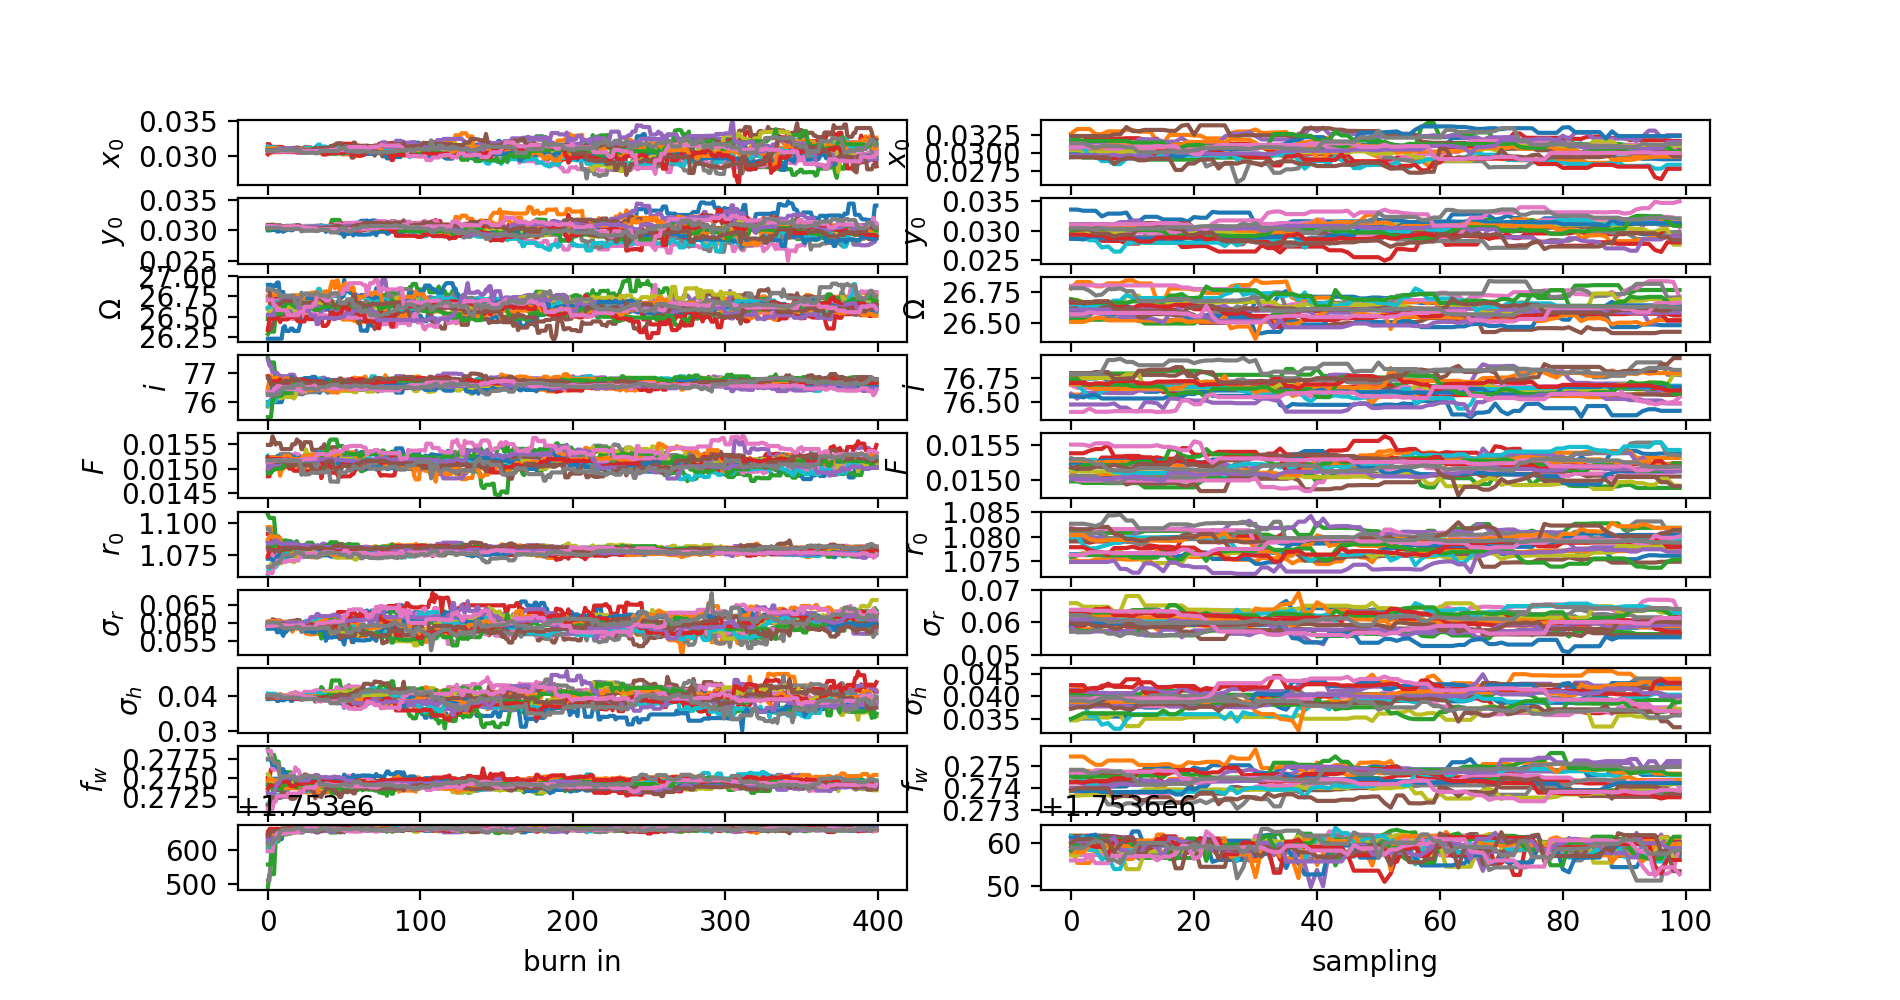

In [16]:
# see what the chains look like, skip a burn in period if desired
burn = 400
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,5),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(ii.params[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
        ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(model_name+'/chains-'+model_name+'.png')

<IPython.core.display.Javascript object>


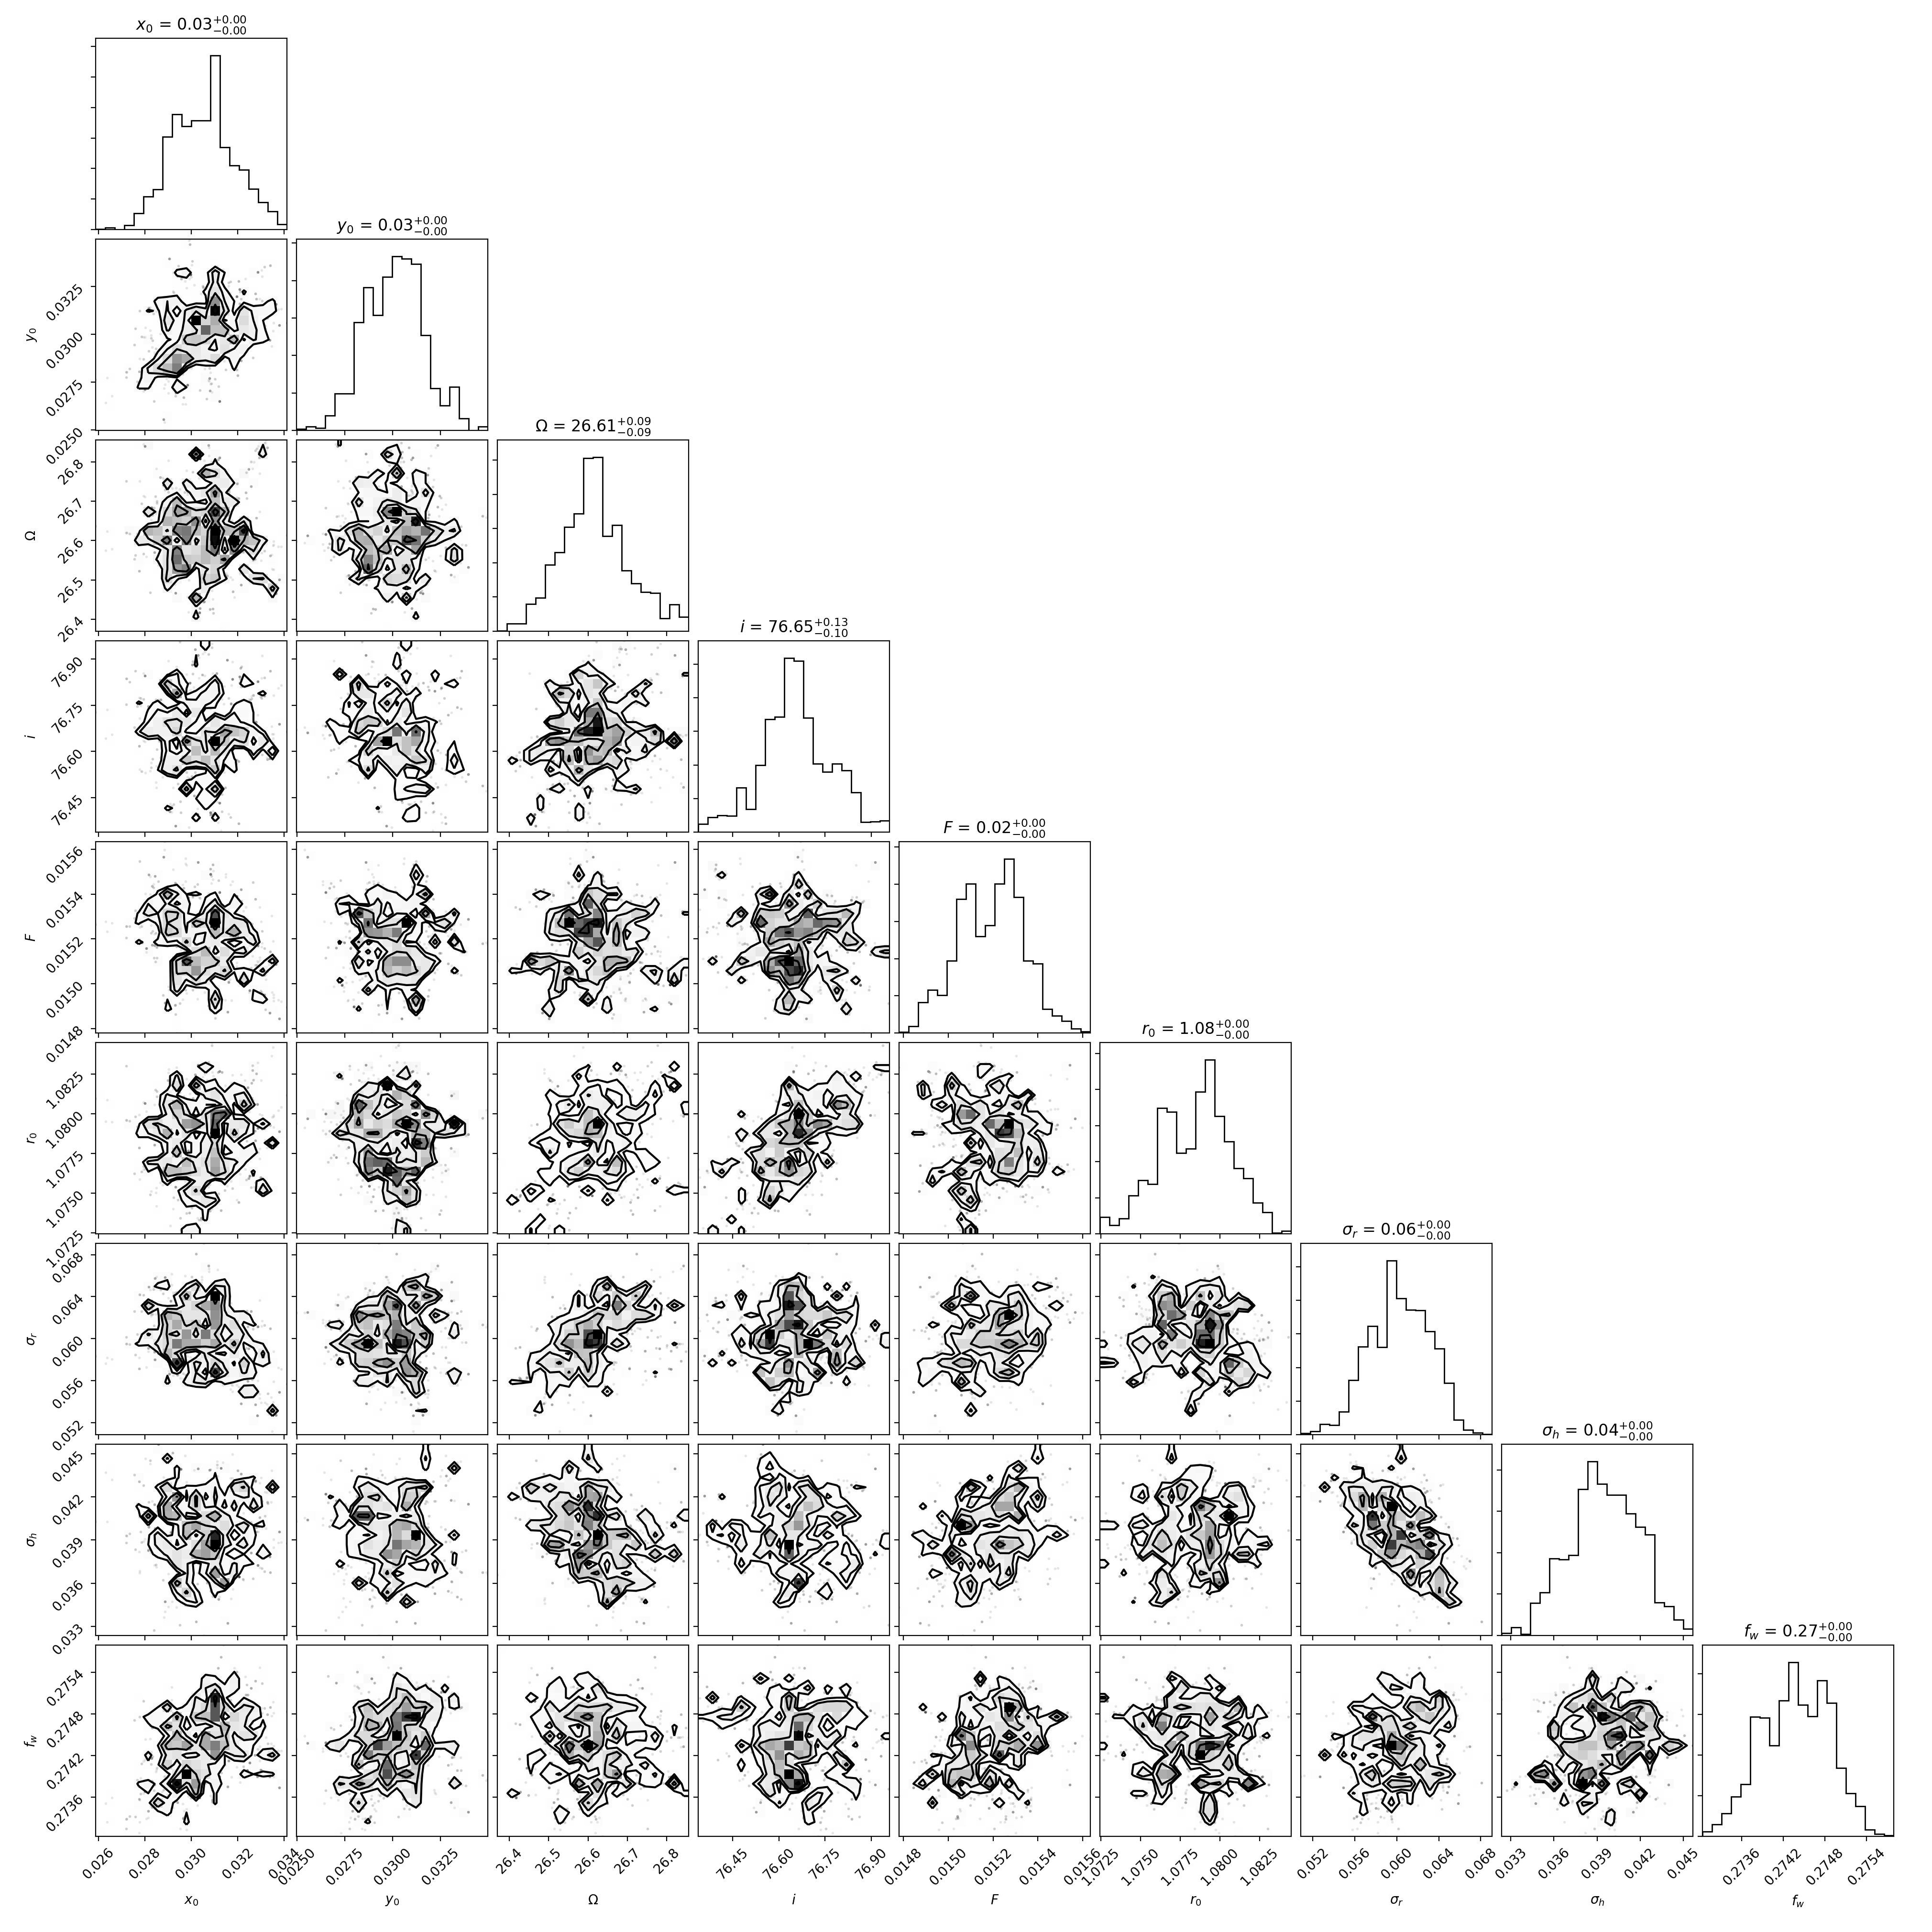

In [17]:
# make the corner plot
fig = corner.corner(sampler.chain[:,burn:,:].reshape((-1,ndim)), labels=ii.params,
                    show_titles=True)

fig.savefig(model_name+'/corner-'+model_name+'.png')

In [18]:
# get the median parameters
p = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)

print('best parameters and uncertainties for {}'.format(model_name))
for i in range(ii.n_params):
    print('{:g}\t{:g}\t{}'.format(p[i],s[i],ii.params[i]))
    
",".join([str(a) for a in p])

best parameters and uncertainties for gauss_3d
0.0305567	0.00135104	$x_0$
0.0301931	0.00152561	$y_0$
26.6124	0.0862484	$\Omega$
76.6511	0.112094	$i$
0.0152039	0.000145881	$F$
1.07877	0.00222303	$r_0$
0.0601259	0.0028305	$\sigma_r$
0.0394892	0.00236803	$\sigma_h$
0.274379	0.000478823	$f_{w}$


'0.03055672268365785,0.030193080666191828,26.612425012519743,76.6511447802873,0.01520392755812371,1.0787724836460835,0.06012588480874448,0.03948916383846749,0.2743794213998664'

radial r_max: 72 pix at 1.618315827559384,1.5990569679453057
model x,y,z extent 41, 66, 70


<IPython.core.display.Javascript object>


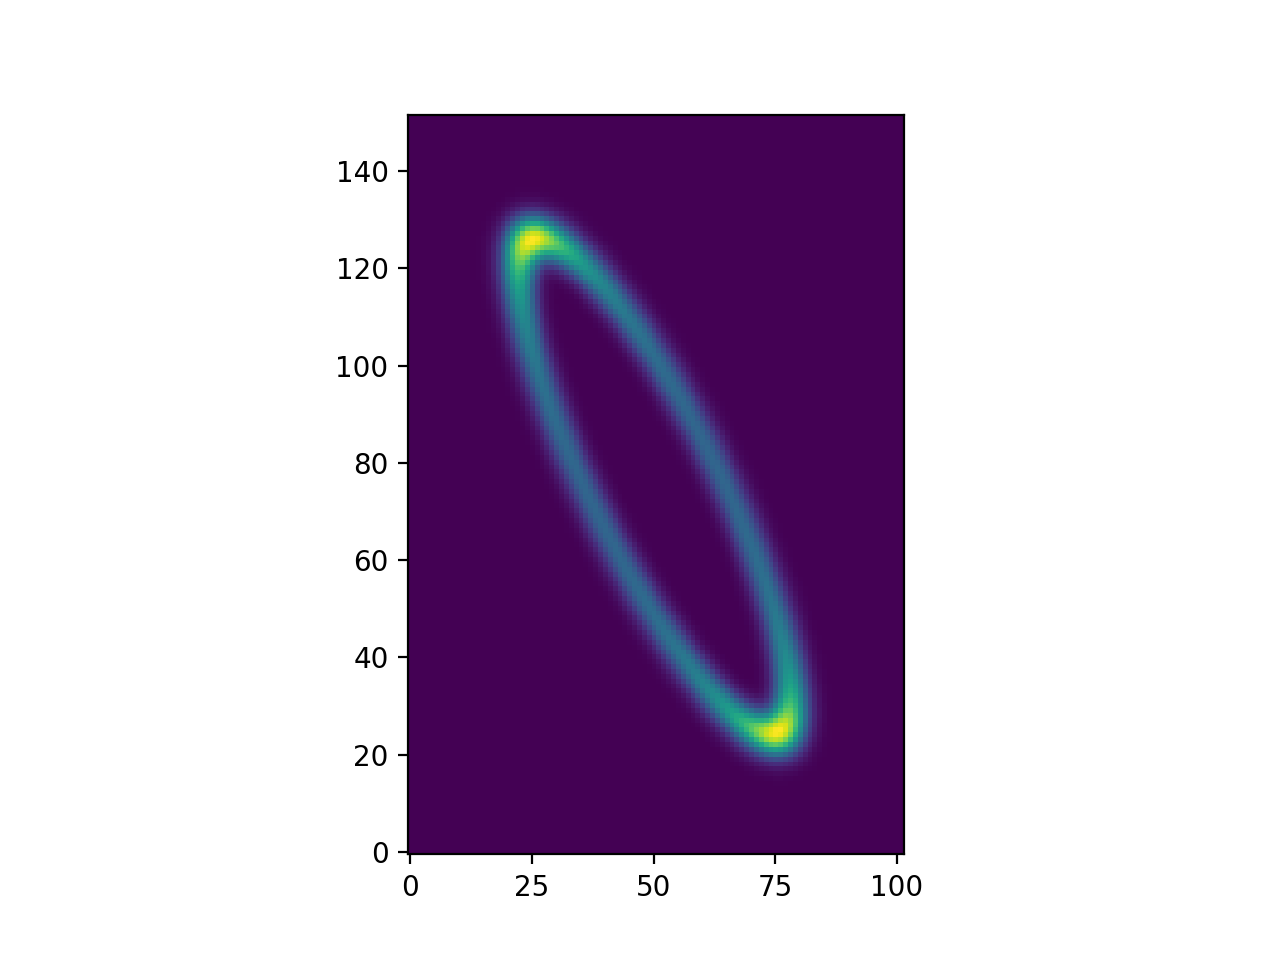

In [19]:
# recompute the limits for the full rotated image
ii.compute_rmax(p)

fig,ax = plt.subplots()
ax.imshow(ii.image(p)[ii.cc], origin='bottom')
fig.savefig(model_name+'/best-'+model_name+'.png')

In [20]:
# save the chains to file
np.savez_compressed(model_name+'/chains-'+model_name+'.npz', sampler.chain, sampler.lnprobability)

In [21]:
# save the visibilities for subtraction from the data
vis_mod = gd.sampleImage(ii.pb_galario * ii.image_galario(p[3:]), dxy, u, v, dRA = p[0]*arcsec, 
                        dDec = p[1]*arcsec, PA = np.deg2rad(p[2]), origin='lower')
np.save(model_name+'/vis-'+model_name+'.npy', vis_mod)

## Creating a map of the residuals
This must be done within CASA. First the script 'residual' is run to subtract the model visibilities created above from the ms we made at the top.
```python
import alma.casa
alma.casa.residual('calibrated.split.cont.w32-t20.ms',
                   'vis-gauss_3d.npy', tb, datacolumn='DATA')
```
Then this is imaged using clean, with something like:
```python
tclean(vis='residual.ms',imagename='residual',imsize=[256,256],cell='0.1arcsec',interactive=False, niter=0)
```
This image can be checked out with viewer(), or saved to a FITS image.

<IPython.core.display.Javascript object>


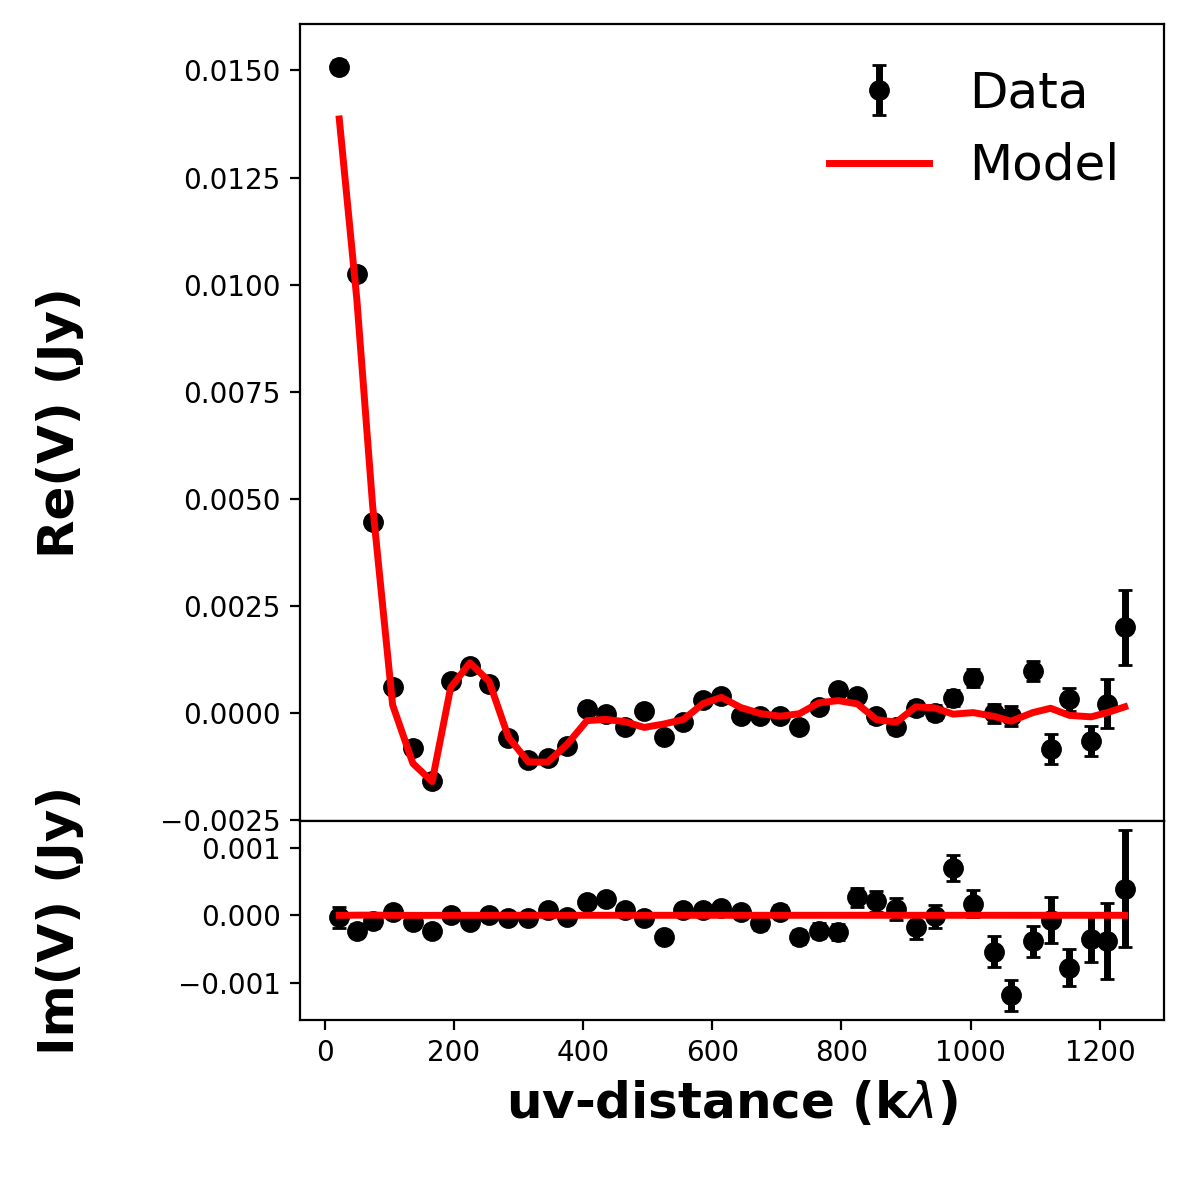

Masking 0 uv bins
Masking 0 uv bins


In [22]:
# make a uv distance plot, needs uvplot from mtazzari
from uvplot.uvtable import UVTable
from uvplot import COLUMNS_V0

uvbin_size = 30e3     # uv-distance bin [wle]

uv = UVTable([u, v, Re, Im, w], columns=COLUMNS_V0)
uv.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv.deproject(np.deg2rad(p[2]), np.deg2rad(p[1]))

uv_mod = UVTable(uvtable=(u, v, np.real(vis_mod), np.imag(vis_mod), w),
                 columns=COLUMNS_V0)
uv_mod.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv_mod.deproject(np.deg2rad(p[2]), np.deg2rad(p[1]))

axes = uv.plot(label='Data', uvbin_size=uvbin_size)
uv_mod.plot(label='Model', uvbin_size=uvbin_size, axes=axes, yerr=False, linestyle='-', color='r')
axes[0].figure.savefig(model_name+'/uvplot-'+model_name+'.png')